Загружаем данные из файла

In [ ]:
import pandas as pd

url = 'https://drive.google.com/file/d/1tEQTEU9JXsqMR7VfqcJ4CVR2Vz9Qd7yD/view?usp=share_link'
file_id = url.split('/')[-2]
data_url = 'https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(data_url)
data

,Page,URL,Title,Text,Type
0,1,https://topcor.ru/34670-v-litve-iskljuchili-vo...,В Литве исключили возможность вступления Украи...,Украина не сможет вступить в Североатлантическ...,Политика
1,1,https://topcor.ru/34672-tolko-pobediv-v-svo-ro...,Только победив в СВО Россия поставит на место ...,За последние годы наглость русофобов дошла до ...,Политика
2,1,https://topcor.ru/34668-ukrainskaja-sau-gvozdi...,Украинская САУ «Гвоздика» не выдержала попадан...,Новости об очередной удачной охоте российского...,Техно
3,1,https://topcor.ru/34669-vsu-budet-tjazhelo-pro...,ВСУ будет тяжело прорваться через линию оборон...,Для украинских военных станет тяжелым испытани...,Политика
4,1,https://topcor.ru/34667-moskva-nam-ne-vrag-pri...,«Москва нам не враг»: Пригожин рассказал об от...,Основатель ЧВК «Вагнер» Евгений Пригожин дал б...,Общество
...,...,...,...,...,...
93,5,https://topcor.ru/34553-eurostat-dokazal-polzu...,Eurostat доказал пользу российского газа для Е...,"Статистика и точные факты – упрямая вещь, особ...",Экономика
94,5,https://topcor.ru/34556-tac-amerikancam-nado-o...,TAC: американцам нужно обезвредить Блинкена и ...,Америка развязала ничем не оправданные войны в...,Политика
95,5,https://topcor.ru/34555-bloomberg-evropejskie-...,Bloomberg: европейские санкции и исторический ...,Если 2022 год можно назвать временем эйфории и...,Экономика
96,5,https://topcor.ru/34550-v-murmanskoj-oblasti-u...,В Мурманской области упал истребитель-перехват...,Во время учебного полета в Мончегорске (Мурман...,Техно


Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
!pip install simplemma
import simplemma
!pip install stop_words
from stop_words import get_stop_words
%pip install pymorphy2
import nltk
nltk.download('stopwords')
import string
stopwords = set(nltk.corpus.stopwords.words('russian'))
punctuations = set(string.punctuation)
import pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Визуализация новостей по типам

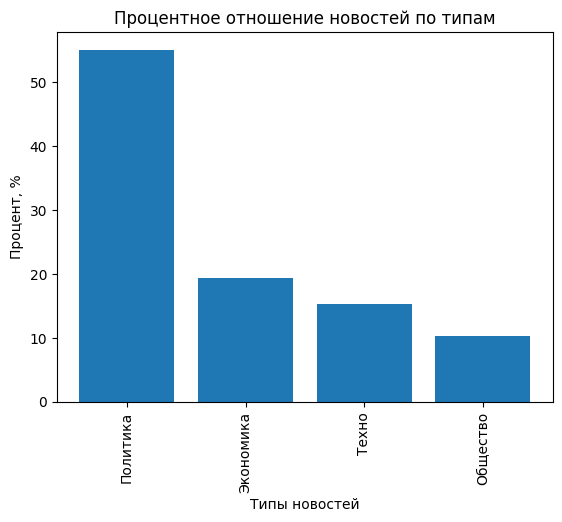

In [ ]:
sum = data['Type'].value_counts().sum() # общее кол-во новостей
percentage = data['Type'].value_counts() / sum * 100 # подсчет долей каждого типа новостей

plt.bar(percentage.index, percentage.values)

plt.title('Процентное отношение новостей по типам')
plt.xlabel('Типы новостей')
plt.ylabel('Процент, %')
plt.xticks(rotation=90)
plt.show()

Функции для подготовки текста

In [ ]:
def preprocess(text):
    text = ''.join(ch for ch in text if ch not in punctuations) # Убираем знаки препинания
    text = text.lower()  # Переводим текст в нижний регистр
    text = ' '.join(word for word in text.split() if word not in stopwords) # Убираем стоп слова

    return text

def lemmatize(text):
    morph = pymorphy2.MorphAnalyzer()
    tokens = text.split() # разбиваем текст на токены
    lemmas = [morph.parse(token)[0].normal_form for token in tokens] # Систематизируем токены
    lemmatized_text = ' '.join(lemmas) # Добавляем лемму в текст

    return lemmatized_text

Подготовка текста

In [ ]:
data['Text'] = data['Text'].apply(preprocess, lemmatize)

Векторизация текстов новостей с помощью TF-IDF

In [ ]:
text = TfidfVectorizer().fit_transform(data['Text'])

Выбор числа кластеров методом локтя

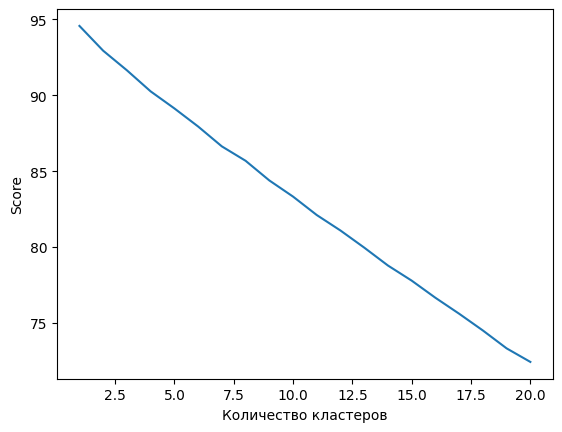

In [ ]:
# Строим график суммы квадратов расстояний от точек до центроидов в зависимости от числа кластеров
score = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k).fit(text)
    kmeans.fit(text)
    score.append(kmeans.inertia_)
plt.plot(range(1, 21), score)
plt.xlabel("Количество кластеров")
plt.ylabel("Score")
plt.show()

Кластеризация, оценка кластеризации по RAND Index

In [ ]:
# Кластеризуем векторы новостей с помощью K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
y_test = kmeans.fit_predict(text)
# Оцениваем качество кластеризации по RAND Index
# Сравниваем метки кластеров с истинными метками типов новостей
y_train = data["Type"]
ari = adjusted_rand_score(y_train, y_test)
print(f"Rand Index: {ari}")
#Adjusted Rand Index (ARI) - это мера сходства между двумя разбиениями данных на кластеры.
#Она принимает значения от -1 до 1, где 1 означает полное совпадение, 0 означает случайное разбиение, а -1 означает полное несовпадение.

Rand Index: 0.24044528863730832


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Обучение классификатора, проверка точности классификатора

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text, data['Type'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape[0] #Кол-во тренировочных новостей

78

In [ ]:
X_test.shape[0] #Кол-во тестовых новостей

20

In [ ]:
clf = LogisticRegression()

# Обучаем логистическую регрессию как классификатор
clf.fit(X_train, Y_train)

# Делаем предсказание
y_pred = clf.predict(X_test)

# Проверяем точность работы классификатора
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6
